In [1]:
import pandas as pd
from report_manager import project, dataset, report, analyses, plots
import networkx as nx
from networkx.readwrite import json_graph
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from scipy.stats import zscore
init_notebook_mode(connected=True)
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

/Users/albertosantos/miniconda3/envs/venv/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:180: UserWarning:

R object inheriting from "POSIXct" but without attribute "tzone".

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertosantos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
my_project = project.Project(identifier='P0000001', datasets=None, report={})

In [3]:
proteomics_dataset = my_project.get_dataset('proteomics')

In [4]:
my_project.list_datasets()

dict_keys(['multiomics', 'clinical', 'proteomics'])

In [5]:
my_project.get_dataset('proteomics').list_dataframes()

['correlation correlation',
 'go annotation',
 'number of modified proteins',
 'number of peptides',
 'number of proteins',
 'original',
 'pathway annotation',
 'processed',
 'protein biomarkers',
 'regulated',
 'regulation table']

In [6]:
proteomics_dataset = my_project.get_dataset('proteomics')
processed_df = proteomics_dataset.get_dataframe('processed')

In [7]:
processed_df.head()

,A2M~P01023,A30~A2MYE2,ABI3BP~Q7Z7G0,ACE~P12821,ACTB~P60709,ACTN1~P12814,ADA2~Q9NZK5,ADAMTS13~Q76LX8,ADAMTSL4~Q6UY14,ADH4~P08319,...,VIM~P08670,VK3~A2N2F4,VNN1~O95497,VTN~P04004,VWF~P04275,YWHAZ~P63104,group,sample,scFv~Q65ZC9,subject
0,38.005564,28.173504,21.491741,23.511264,27.090330,25.039968,23.442151,24.010605,25.085820,23.389032,...,24.178889,25.835908,22.480055,32.815815,28.922779,20.903892,Cirrhosis,AS68,27.788928,S68
1,37.309118,27.981907,27.342062,23.847270,27.461155,25.896268,23.754503,24.135818,24.735056,22.148706,...,23.709777,25.004889,23.852908,32.722121,29.881279,22.141285,Cirrhosis,AS69,26.869972,S69
2,37.384952,28.857627,21.988093,22.863630,27.929764,24.295225,23.359443,24.121788,24.923476,23.017163,...,23.599064,26.271650,24.232132,32.755752,29.444625,20.534920,Cirrhosis,AS70,28.069328,S70
3,38.417225,28.978380,25.501910,22.992774,27.152479,25.231288,23.701340,24.568309,24.878802,26.388112,...,24.179076,25.929200,24.269047,32.714014,29.397176,22.216971,Cirrhosis,AS71,28.170209,S71
4,37.471303,28.748744,19.513801,23.872356,27.537048,22.392992,22.406264,24.961173,24.912283,24.339540,...,23.865224,26.701340,23.147062,32.722691,28.540895,21.797507,Cirrhosis,AS72,28.612280,S72


In [8]:
processed_df = processed_df.drop(['sample', 'subject'], axis=1).set_index('group').apply(zscore).reset_index()

In [9]:
proteomics_report = my_project.get_dataset('proteomics').report

In [19]:
#proteomics_report.list_plots()

In [20]:
#proteomics_report.visualize_plot(environment='notebook', plot_type='13~correlation_correlation~network')

In [12]:
correlation_net_dict = proteomics_report.get_plot('13~correlation_correlation~network')[0]

In [13]:
correlation_net = json_graph.node_link_graph(correlation_net_dict['net_json'])

In [14]:
correlation_df = pd.DataFrame.from_dict(correlation_net.nodes(data=True))
correlation_df = correlation_df[0].to_frame().join(correlation_df[1].apply(pd.Series))

In [15]:
correlation_df.columns = ['identifier', 'degree', 'radius', 'color', 'cluster']

In [16]:
min_val = processed_df._get_numeric_data().min().min().round()
max_val = processed_df._get_numeric_data().max().max().round()
processed_df = processed_df[list(correlation_df.identifier) + ['group']]

In [17]:
from IPython.core.display import display, HTML

       group  APOC3~P02656  APOC1~K7ERI9  APOC4-APOC2~K7ER74  APOM~O95445  \
0  Cirrhosis     -1.127315     -0.214552           -1.168566    -0.604560   
1  Cirrhosis     -0.070540     -0.649523           -0.475596    -1.513314   
2  Cirrhosis     -0.113590      0.115950           -0.785811     0.001908   
3  Cirrhosis     -2.118845     -2.203866           -1.622242    -1.314763   
4  Cirrhosis     -0.879386     -0.961242           -1.780558    -0.282497   

   CDH5~P33151  OLFM1~Q99784  
0     1.457187     -0.883363  
1     1.038317      0.874384  
2     0.071279      0.459700  
3     1.555195      0.167477  
4    -0.484155     -0.112847  


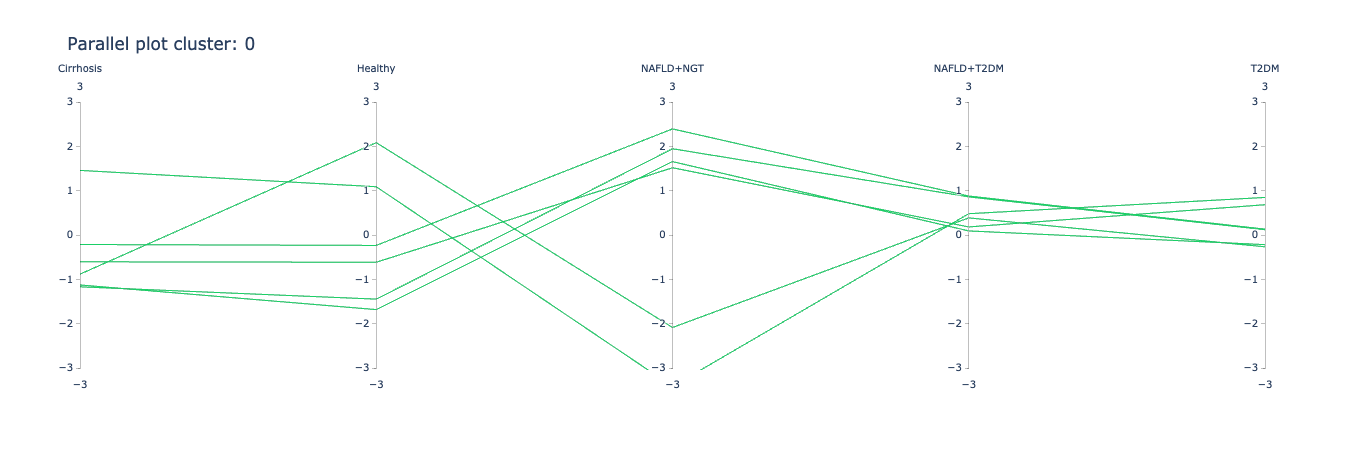

In [21]:
@interact
def plot_parallel_plot(cluster=correlation_df.cluster.unique()):
    cluster_colors = dict(zip(correlation_df.cluster, correlation_df.color))
    clusters = correlation_df.groupby('cluster')
    identifiers = clusters.get_group(cluster)['identifier'].tolist()
    title= "Parallel plot cluster: {}".format(cluster)
    df = processed_df.set_index('group')[identifiers].reset_index()
    print(df.head())
    figure = plots.basicFigures.get_parallel_plot(df, identifier=cluster, args={'color':cluster_colors[cluster], 'group':'group', 
                                                                          'title':title,
                                                                          'zscore':False})
    display(HTML("<p>{}</p>".format(",".join(identifiers))))
    iplot(figure.figure)